In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [3]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv1D,Dense, GlobalAveragePooling1D, Embedding, MultiHeadAttention
from tensorflow.keras.layers import MaxPool1D, Dropout, LayerNormalization, MaxPooling1D, Input
from tensorflow.keras.models import Sequential, Model

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2022-03-28 18:26:20.876204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 18:26:20.881266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-28 18:26:20.881617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
weight_address = 'weights2/'
results_address = 'results2/'
NUM_CLASSES = 6

### The networks

#### Transformer

In [5]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.embed_dim = embed_dim
        self.token_emb = Embedding(input_dim= vocab_size, output_dim= embed_dim)
        self.maxlen = maxlen
        # self.pos_emb = Embedding(input_dim= maxlen, output_dim= embed_dim)

    def get_angles(self, pos, i, embd_dim):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(embd_dim))
        return pos * angle_rates

    def positional_encoding(self, max_pos_enc, embd_dim):
        angle_rads = self.get_angles(np.arange(max_pos_enc)[:, np.newaxis],
                                np.arange(embd_dim)[np.newaxis, :],
                                embd_dim)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x):
        # positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.positional_encoding(max_pos_enc= self.maxlen, embd_dim= self.embed_dim)
        # print(positions.shape)
        # positions = self.pos_encoding(positions)
        x = self.token_emb(x)
        # print(x.shape)
        return x + positions

In [6]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads= num_heads, key_dim= embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        # print('out1.shape:', out1.shape)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        # print('ffn_output.shape:', ffn_output.shape)
        return self.layernorm2(out1 + ffn_output)

### Transformer and CNN

In [7]:
@tf.autograph.experimental.do_not_convert # added to silence a warning related to TF
def create_model_cnn_transformer(maxlen = 30121, vocab_size = 259,
                                embed_dim = 50, num_heads = 2, 
                                ff_dim = 16, dout = 0.1,
                                filters = 64, kernel_size = 3, 
                                pool_window = 2, extra_dense_nodes = 20, 
                                max_pool = True, summary = True):
    '''
    embed_dim - Embedding size for each token
    num_heads - Number of attention heads
    ff_dim - Hidden layer size in feed forward network inside transformer
    pool - can be "maxpool" for local maxpooling or "globalAvg" for global average pooling
    '''
    # input
    inputs = Input(shape=(maxlen,))
    # embeddding
    embedding_layer = TokenAndPositionEmbedding(inputs.shape[1], vocab_size, embed_dim)
    x = embedding_layer(inputs)
    # convolution
    x = Conv1D(filters= filters, kernel_size= kernel_size)(x)
    if max_pool == True:
        x = MaxPooling1D(pool_size= pool_window)(x)
   
    # transformer
    transformer_block = TransformerBlock(filters, num_heads, ff_dim)
    x = transformer_block(x)
    # extra dense layers
    x = GlobalAveragePooling1D()(x)
    if extra_dense_nodes!= 0:
        x = Dense(extra_dense_nodes, activation= "relu")(x)
        x = Dropout(dout)(x)
    
    # output
    outputs = Dense(NUM_CLASSES, activation= "softmax")(x)

    model= Model(inputs=inputs, outputs= outputs)
    if summary:
        model.summary()
    
    return model

### CNN

In [8]:
def create_CNN_model(layers = 2, filters = [32, 64, 128], kernel_size= 3,
                      embed_dim = 50, vocab_size = 259, summary= False):

    model = Sequential()
    model.add(Embedding(vocab_size+1, embed_dim))#, input_length = X_train_padded.shape[1]))
    
    for i in range(layers):
        model.add(Conv1D(filters = filters[i], kernel_size = kernel_size, activation='relu'))
        model.add(MaxPool1D(pool_size = 2, strides=2))

    model.add(GlobalAveragePooling1D())
    model.add(Dense(NUM_CLASSES, activation= 'softmax'))
    if summary:
        model.summary()
    return model

### Kmer method

#### Loading the saved data

In [9]:
with open('X_train_k3_med.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('Y_train_k3.pkl', 'rb') as f:
    Y_train = pickle.load(f)
    
X_train.shape, Y_train.shape

((1500, 20557), (1500,))

In [10]:
MAXLEN = X_train.shape[1]
MAXLEN

20557

In [11]:
with open('X_test_list_k3_med.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('Y_test_list_k3.pkl', 'rb') as f:
    Y_test = pickle.load(f)

X_test[0].shape, Y_test[0].shape    

((1090, 20557), (1090,))

#### Training helpers

In [12]:
model_names = ['transformer_cnn_k3_32f_4pool',
            'transformer_cnn_k3_64f_4pool',
            'transformer_cnn_k3_128f_4pool',
            'transformer_cnn_k3_32f_globalAvg',
            'cnn_k3_2layers']

In [13]:
lr_decay = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose= 1
    )

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    verbose=1,
    patience=5,
    mode="auto",
    restore_best_weights=True,
)

adam_opt = tf.keras.optimizers.Adam(learning_rate= 3e-3)

In [14]:
def evaluate_model(model, model_name):
    test_indicies = [2,3,4,5,1]

    model.load_weights(weight_address+model_name) # loads the best weight before evaluating
    for i in range(5):
        print('Test set {} F1 score:'.format(test_indicies[i]))
        preds = np.argmax(model.predict(X_test[i], batch_size=4), axis = 1)
        score = f1_score(Y_test[i], preds, average = 'weighted')
        print(score)
        with open(results_address+model_name+'_test_results.txt','a') as f:
            f.write('Test set '+str(test_indicies[i])+' F1 score:')
            f.write('\n'+str(score))
            f.write('\n===\n')

In [15]:
def plot_history(history, model_name):
    print('Highest train acc: {:.3f} epoch: {}\nHighest val acc: {:.3f} epoch: {}'\
        .format(max(history.history['accuracy']), 1+np.argmax(np.array(history.history['accuracy'])),
                max(history.history['val_accuracy']), 1+np.argmax(np.array(history.history['val_accuracy']))))

    plt.title('Training history of '+ model_name)
    plt.plot(history.history['accuracy'],'ro-')
    plt.plot(history.history['val_accuracy'],'bx-')
    plt.legend(['accuracy','val_accuracy'])
    plt.savefig(results_address + model_name+'.png')
    plt.show()

In [16]:
def make_checkpointer(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
    weight_address + model_name, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True)

In [17]:
metrics = ['accuracy']

#### CNN_Transformer

pool size smaller than 4 cannot be run by my GPU

In [18]:
eps = 20 #15

In [23]:
model_name = model_names[0]
print(model_name)

check_point = make_checkpointer(model_name)
model = create_model_cnn_transformer(filters= 32, maxlen=MAXLEN, pool_window=4, summary= True)

model.compile(optimizer= adam_opt, loss= "sparse_categorical_crossentropy", metrics= metrics)

transformer_cnn_k3_32f_4pool
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 20557)]           0         
                                                                 
 token_and_position_embeddin  (None, 20557, 50)        12950     
 g_3 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 20555, 32)         4832      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 5138, 32)         0         
 1D)                                                             
                                                                 
 transformer_block_3 (Transf  (None, 5138, 32)         9616      
 ormerBlock)                  

Epoch 1/20
375/375 [==============================] - 48s 125ms/step - loss: 0.9344 - accuracy: 0.5247 - val_loss: 0.6397 - val_accuracy: 0.7248 - lr: 0.0030
Epoch 2/20
375/375 [==============================] - 47s 126ms/step - loss: 0.5751 - accuracy: 0.6720 - val_loss: 0.6154 - val_accuracy: 0.6798 - lr: 0.0030
Epoch 3/20
375/375 [==============================] - 48s 127ms/step - loss: 0.7352 - accuracy: 0.6573 - val_loss: 0.4167 - val_accuracy: 0.8734 - lr: 0.0030
Epoch 4/20
375/375 [==============================] - 47s 126ms/step - loss: 0.4328 - accuracy: 0.7620 - val_loss: 0.3865 - val_accuracy: 0.8294 - lr: 0.0030
Epoch 5/20
375/375 [==============================] - 47s 124ms/step - loss: 0.3183 - accuracy: 0.8433 - val_loss: 0.3543 - val_accuracy: 0.9514 - lr: 0.0030
Epoch 6/20
375/375 [==============================] - 46s 124ms/step - loss: 0.2190 - accuracy: 0.9013 - val_loss: 0.3528 - val_accuracy: 0.9569 - lr: 0.0030
Epoch 7/20
375/375 [==============================] 

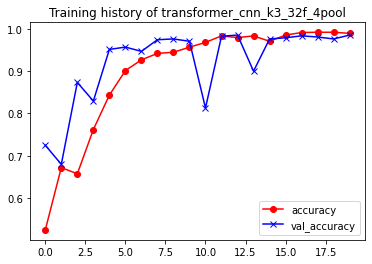

Test set 2 F1 score:
0.9703125235128376
Test set 3 F1 score:
0.9908444531332044
Test set 4 F1 score:
0.9928641790139182
Test set 5 F1 score:
0.9889335827022537
Test set 1 F1 score:
0.9909770620579825


In [24]:
history = model.fit(X_train, Y_train,
                    batch_size=4, epochs=eps,
                    validation_data=(X_test[0], Y_test[0]),
                    callbacks = [check_point, lr_decay])

plot_history(history, model_name)
evaluate_model(model, model_name)
# tf.keras.utils.plot_model(cnn_transformer1, to_file='cnn_transformer_32f_4pool.png', show_shapes=True)

In [27]:
model_name = model_names[1]
print(model_name)
check_point = make_checkpointer(model_name)

model = create_model_cnn_transformer(filters=64,maxlen=MAXLEN, pool_window=4, summary= True)

model.compile(optimizer= adam_opt, loss= "sparse_categorical_crossentropy", metrics=metrics)

transformer_cnn_k3_64f_4pool
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 20557)]           0         
                                                                 
 token_and_position_embeddin  (None, 20557, 50)        12950     
 g_5 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 20555, 64)         9664      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 5138, 64)         0         
 1D)                                                             
                                                                 
 transformer_block_5 (Transf  (None, 5138, 64)         35600     
 ormerBlock)                  

Epoch 1/20
375/375 [==============================] - 54s 143ms/step - loss: 0.8640 - accuracy: 0.5867 - val_loss: 0.5606 - val_accuracy: 0.7275 - lr: 0.0015
Epoch 2/20
375/375 [==============================] - 53s 142ms/step - loss: 0.5080 - accuracy: 0.7413 - val_loss: 0.4604 - val_accuracy: 0.7936 - lr: 0.0015
Epoch 3/20
375/375 [==============================] - 52s 138ms/step - loss: 0.4372 - accuracy: 0.7540 - val_loss: 0.4073 - val_accuracy: 0.7954 - lr: 0.0015
Epoch 4/20
375/375 [==============================] - 52s 139ms/step - loss: 0.3909 - accuracy: 0.7667 - val_loss: 0.4017 - val_accuracy: 0.7945 - lr: 0.0015
Epoch 5/20
375/375 [==============================] - 52s 139ms/step - loss: 0.3780 - accuracy: 0.7747 - val_loss: 0.4070 - val_accuracy: 0.7963 - lr: 0.0015
Epoch 6/20
375/375 [==============================] - 52s 139ms/step - loss: 0.3432 - accuracy: 0.8040 - val_loss: 0.3873 - val_accuracy: 0.8917 - lr: 0.0015
Epoch 7/20
375/375 [==============================] 

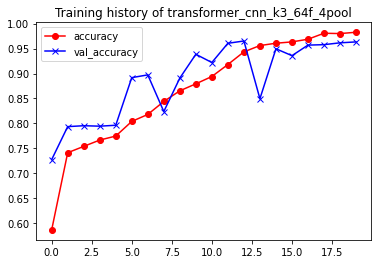

Test set 2 F1 score:
0.9601971680588735
Test set 3 F1 score:
0.9660542602104704
Test set 4 F1 score:
0.9676096733849511
Test set 5 F1 score:
0.9715387184511843
Test set 1 F1 score:
0.9404883236380629


In [28]:
history = model.fit(X_train, Y_train,
                    batch_size=4, epochs=eps,
                    validation_data=(X_test[0], Y_test[0]),
                    callbacks = [check_point, lr_decay])

plot_history(history, model_name)
evaluate_model(model, model_name)

# tf.keras.utils.plot_model(cnn_transformer1, to_file='cnn_transformer_32f_4pool.png', show_shapes=True)

In [26]:
model_name = model_names[2]
print(model_name)
check_point = make_checkpointer(model_name)


model = create_model_cnn_transformer(filters=128, maxlen=MAXLEN, pool_window=4, summary= True)

model.compile(optimizer= adam_opt, loss= "sparse_categorical_crossentropy", metrics=['accuracy'])


transformer_cnn_k3_128f_4pool
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20557)]           0         
                                                                 
 token_and_position_embeddin  (None, 20557, 50)        12950     
 g_2 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 20555, 128)        19328     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 5138, 128)        0         
 1D)                                                             
                                                                 
 transformer_block_2 (Transf  (None, 5138, 128)        136720    
 ormerBlock)                 

Epoch 1/30
375/375 [==============================] - 61s 160ms/step - loss: 1.5208 - accuracy: 0.2740 - val_loss: 1.2748 - val_accuracy: 0.3706 - lr: 0.0030
Epoch 2/30
375/375 [==============================] - 60s 160ms/step - loss: 1.1218 - accuracy: 0.4627 - val_loss: 0.7515 - val_accuracy: 0.6284 - lr: 0.0030
Epoch 3/30
375/375 [==============================] - 60s 160ms/step - loss: 0.7014 - accuracy: 0.6393 - val_loss: 0.6378 - val_accuracy: 0.7009 - lr: 0.0030
Epoch 4/30
375/375 [==============================] - 60s 161ms/step - loss: 0.6602 - accuracy: 0.6507 - val_loss: 0.6685 - val_accuracy: 0.7018 - lr: 0.0030
Epoch 5/30
375/375 [==============================] - 60s 160ms/step - loss: 0.6486 - accuracy: 0.6487 - val_loss: 0.6622 - val_accuracy: 0.6330 - lr: 0.0030
Epoch 6/30
375/375 [==============================] - 58s 156ms/step - loss: 0.6588 - accuracy: 0.6500 - val_loss: 0.5268 - val_accuracy: 0.8211 - lr: 0.0030
Epoch 7/30
375/375 [==============================] 

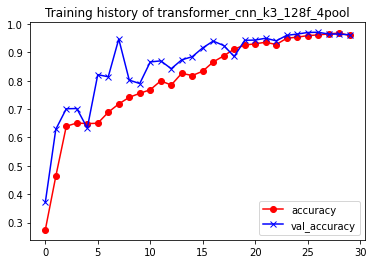

Test set 2 F1 score:
0.9419605287397811
Test set 3 F1 score:
0.8988501739103574
Test set 4 F1 score:
0.9123703025983049
Test set 5 F1 score:
0.9216075243058601
Test set 1 F1 score:
0.8062399566057783


In [27]:
history = model.fit(X_train, Y_train,
                    batch_size=4, epochs=30,
                    validation_data=(X_test[0], Y_test[0]),
                    callbacks = [check_point, lr_decay])

plot_history(history, model_name)
evaluate_model(model, model_name)

# tf.keras.utils.plot_model(cnn_transformer1, to_file='cnn_transformer_32f_4pool.png', show_shapes=True)

In [28]:
model_name = model_names[4]
print(model_name)

check_point = make_checkpointer(model_name)
model = create_CNN_model(layers=2, kernel_size=3)

cnn_k3_2layers
The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


Epoch 1/20
375/375 [==============================] - 3s 8ms/step - loss: 0.6778 - accuracy: 0.6667 - val_loss: 1.6077 - val_accuracy: 0.7339 - lr: 0.0015
Epoch 2/20
375/375 [==============================] - 3s 8ms/step - loss: 0.5122 - accuracy: 0.7380 - val_loss: 2.4563 - val_accuracy: 0.9881 - lr: 0.0015
Epoch 3/20
375/375 [==============================] - 3s 7ms/step - loss: 0.1752 - accuracy: 0.9607 - val_loss: 2.7359 - val_accuracy: 0.9890 - lr: 0.0015
Epoch 4/20
375/375 [==============================] - 3s 7ms/step - loss: 0.0492 - accuracy: 0.9940 - val_loss: 3.4208 - val_accuracy: 0.9908 - lr: 0.0015
Epoch 5/20
375/375 [==============================] - 3s 7ms/step - loss: 0.0159 - accuracy: 0.9980 - val_loss: 3.5830 - val_accuracy: 0.9908 - lr: 0.0015
Epoch 6/20
369/375 [============================>.] - ETA: 0s - loss: 0.0074 - accuracy: 0.9986
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.000750000006519258.
Restoring model weights from the end of the best e

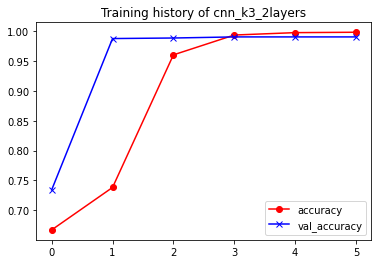

Test set 2 F1 score:
0.6538701115934199
Test set 3 F1 score:
0.8852889798327304
Test set 4 F1 score:
0.899521032098069
Test set 5 F1 score:
0.8570410719937213
Test set 1 F1 score:
0.9377791911728759


In [29]:
model.compile(optimizer= adam_opt, loss= "sparse_categorical_crossentropy", metrics= metrics)

history = model.fit(X_train, Y_train,
                    batch_size=4, epochs=eps,
                    validation_data=(X_test[0], Y_test[0]),
                    callbacks = [check_point, lr_decay, es])

plot_history(history, model_name)
evaluate_model(model, model_name)
# tf.keras.utils.plot_model(cnn_transformer1, to_file=model_name+'.png', show_shapes=True)